In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
import cPickle as pickle
from string import punctuation
from nltk import word_tokenize
from nltk.stem import snowball
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import PunktSentenceTokenizer
import time
import seaborn as sb
%matplotlib inline


stemmer = snowball.SnowballStemmer("english")

/home/mgupta/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def build_roc(df):
    
    df['TPR'] = df['recall']
    df['FPR'] = df['FP']/(df['FP'] + df['TN'])
    
#     plt.plot([0,1],[0,1],'k',linewidth=0.5)
    plt.figure()
    plt.plot(df.FPR.values,df.TPR.values,'r*',markersize=7)
    plt.xlabel('FPR')
    plt.xlim([0,1])
    plt.ylabel('TPR')
    plt.ylim([0,1])
    titlestr = "AUC: {}  k = {}".format(np.trapz(df.TPR.values[::-1],x=df.FPR.values[::-1]),int(df.k.unique()))
    plt.title(titlestr)

In [3]:
resultspath2 = '../../data/gridsearch_modelbase2mini_on_test.csv'
df2 = pd.read_csv(resultspath2)

In [4]:
df2.head()

,Unnamed: 0,k,threshold,accuracy,recall,precision,TP,TN,FN,FP
0,0,11,0.1,0.501078,1.000000,0.500958,2091,1,0,2083
1,1,11,0.2,0.504431,0.999044,0.502647,2089,17,2,2067
2,2,11,0.3,0.527904,0.994261,0.514859,2079,125,12,1959
3,3,11,0.4,0.612934,0.958871,0.567185,2005,554,86,1530
4,4,11,0.5,0.721916,0.889048,0.666786,1859,1155,232,929


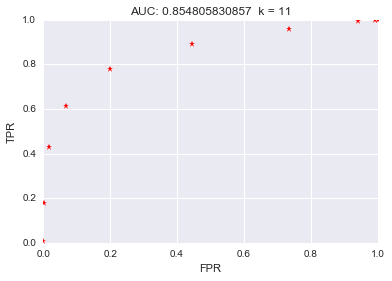

In [5]:
build_roc(df2[df2['k']==11])

In [6]:
resultspath = '../../data/twitter_test_xgboost_doc2vec_results.csv'
dresults = pd.read_csv(resultspath)

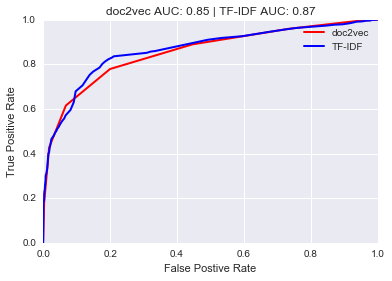

In [11]:
plt.figure()

yvals = df2['recall']
xvals = df2['FP']/(df2['FP'] + df2['TN'])
plt.plot(xvals,yvals,'r',linewidth=2,label='doc2vec')

plt.plot(FPR,TPR,'b',linewidth=2,label='TF-IDF')

plt.xlabel('False Postive Rate')
plt.xlim([0,1])
plt.ylabel('True Positive Rate')
plt.ylim([0,1])
plt.legend()

doc2vecAUC = np.round(np.trapz(yvals[::-1],x=xvals[::-1]),decimals=2)
TFIDF_AUC = np.round(np.trapz(TPR[::-1],x=FPR[::-1]),decimals=2)
titlestr = "doc2vec AUC: {} | TF-IDF AUC: {}".format(doc2vecAUC,TFIDF_AUC)
plt.title(titlestr)
plt.savefig('testROC.jpg')

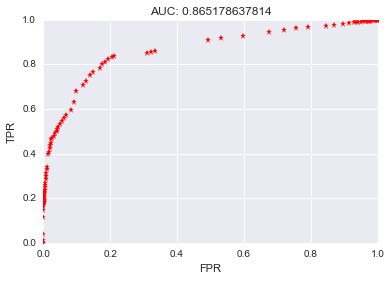

In [8]:
labels = dresults['label'].values
TPR = []
FPR = []

for i in xrange(101):
    threshold = i/100.0
    predict = dresults['xgboost_predict'].values >= threshold
    
    TP = sum(predict+labels==2)
    TN = sum(predict+labels==0)
    FP = sum(predict-labels==1)
    FN = sum(predict-labels==-1)
    
#     print "accuracy: {} | threshold {}".format((TP+TN)/float(len(labels)),threshold)
    
    TPR.append(TP/float(TP+FN))
    FPR.append(FP/float(FP+TN))
    
plt.plot(FPR,TPR,'r*',markersize=7)
plt.xlabel('FPR')
plt.xlim([0,1])
plt.ylabel('TPR')
plt.ylim([0,1])
titlestr = "AUC: {}".format(np.trapz(TPR[::-1],x=FPR[::-1]))
plt.title(titlestr) 

In [6]:
#output from test_model.py on test set with k = 11 and threshold = 0.63
# accuracy: 0.794011976048
# recall: 0.781922525108
# precision: 0.801863658656

# TP: 1635
# TN: 1680

# FN: 456
# FP: 404


In [7]:
def myfunc(x):
    #threshold val chosen from cross val set analysis
    threshold = 0.41
    if x>= threshold:
        return 1
    else:
        return 0

In [8]:
df = dresults.copy()
df['xgbfinal4_predict'] = df['xgboost_predict'].map(lambda x: myfunc(x))

In [9]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1,tweet_text,label,xgboost_predict,doc2vec_predict,xgbfinal4_predict
0,0,1,1,Fuck dykes,1,0.489720,1.0,1
1,1,2,2,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...,1,0.663959,1.0,1
2,2,3,3,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill...",1,0.501306,1.0,1
3,3,9,9,I'm tired of people saying I look like my brot...,1,0.684776,1.0,1
4,4,12,12,I hate faggots like you,1,0.663959,1.0,1


In [10]:
df_agree_good = df[(df['label'] + df['xgbfinal4_predict'] + df['doc2vec_predict']) == 0]

In [18]:
x = df_agree_good['tweet_text'].values
print len(x)
print ""
for i in xrange(5):
    print x[i]
    print ""

1417

RT @Fact: Some species of birds have been known to hold funerals for their deceased.

I remember Draft prom night, my dress wouldn't zip up and I was bawling my eyes out and screaming I didn't want to go... So funny. Haha.

#YouWillNotBeTakenSeriouslyIf you wear shorty shorts and fuzzy boots in negative degree weather.

@LastProtestants @stomponato @delschilling You're an idiot.

@NFLfantasy @Akbar_Gbaja the last thing he cares about is fantasy owners



In [12]:
df_agree_bad = df[(df['label'] + df['xgbfinal4_predict'] + df['doc2vec_predict']) == 3]

In [19]:
x = df_agree_bad['tweet_text'].values
print len(x)
print ""
for i in xrange(5):
    print x[i]
    print ""

1436

Fuck dykes

@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandonernandez @bootyacid at least i dont look like jefree starr faggot

"@jayswaggkillah: "@JacklynAnnn: @jayswaggkillah Is a fag" jackie jealous" Neeeee

I'm tired of people saying I look like my brother &amp; calling me Deondre' like serious Succ My Ass fag asses

I hate faggots like you



In [14]:
df_missed_good = df[(df['label']==0) & (df['xgbfinal4_predict']==1) & (df['doc2vec_predict']==1)]

In [20]:
x = df_missed_good['tweet_text'].values
print len(x)
print ""
for i in xrange(5):
    print x[i]
    print ""

120

I play for keeps you play wit me its gon be yellow tape! #200

You Hotep Black women always bashing Black men. You so ashy  https://t.co/EFNK6bohwN

@precious_sneed lmao deadass, nah them 9's be ashy af too_�㢉�__ people at my school shits be damn near see through

what's spooky blacks instagram _������

@bad_chink oh ok Ima look into it thanks_�㢉�_��_



In [16]:
df_missed_bad = df[(df['label']==1) & (df['xgbfinal4_predict']==0) & (df['doc2vec_predict']==0)]

In [21]:
x = df_missed_bad['tweet_text'].values
print len(x)
print ""
for i in xrange(5):
    print x[i]
    print ""

196

RT @macktology101: "Sunday funday" hoe quotes

RT @AC_Hussle: I'm not giving these hoes free meals so they can go lay up with the dude they can't get over. Nope.

@Independent @JoshuaAssaraf Should check it - He was secretly converted to Islam by Saddamn HouSSein in late 80's. He often says Allah Akbar

I literally HATE this generation. Yall lame like damn... Everybody all act alike &amp; it's annoying

Women: "a man should pay the rent and all the bills, I'm traditional"

Men: keep your body count low

Women: "You're a ashy misogynist!"



In [22]:
df_doc2vec_win = df[(df['label']==df['doc2vec_predict']) & (df['xgbfinal4_predict']!=df['label'])]

In [26]:
x = df_doc2vec_win['tweet_text'].values
print len(x)
print ""
for i in xrange(5):
    print x[i]
    print ""

462

@RiotSupport so I was suspended for a day because of a random lag spikes that force me to close the client and relog and suspended. GG

pollo&#128523;&#128523;&#128523;

RT @HBCUfessions: You females overlook us geeks. When I take these glasses off, I'm no longer Clark Kent. I go superman in that pussy. - FA&#8230;

why is this niggah still tweetn tf !!!!

@suarung heheh thanks sua!! And i thought he was making some other game? (I think it had a batler look-alike in it)



In [24]:
df_doc2vec_lose = df[(df['label']!=df['doc2vec_predict']) & (df['xgbfinal4_predict']==df['label'])]

In [28]:
x = df_doc2vec_lose['tweet_text'].values
print len(x)
print ""
for i in xrange(5):
    print x[i]
    print ""

544

RT @BitchPlsComedy: apparently &#8220;bae&#8221; means &#8220;before anyone else&#8221; i always thought it was a ghetto word for &#8220;babe&#8221;

RT @YepillPosts: If I had a dollar for every time I died on flappy bird http://t.co/pj8QSBTe2L

MUSLIM IMMIGRANT Chanted �ʉ�Ӊ��Allahu Akbar�ʉ��� While Raping Gas Station Attendent�ʉ��_Refuses To Appear In... https://t.co/QyLqFM60Dj

Just smashing a akbar with @TyroneLarkham @LarkhamWilliam @1jamesmitchell @philmaguire3

Eyewitness claims Las Vegas vehicle attack carried out by Muslim  screaming 'Allahu Akbar'... media blackout.. https://t.co/6HnWmkIo8d #tcot

